# Using **Prophet & XGBoost** for raw material demand forecasting

**Notebook functionality:**


*   Find the best parameters to use Prophet model for demand forecasting on a given time series dataset.
*   Use Prophet to forecast demand of raw materials for specified period of time.

*   Find the best parameters to use XGBoost model for demand forecasting on a given time series dataset.
*   Use XGBoost to forecast demand of raw materials for specified period of time.
*   Compare performance of XGBoost vs Prophet and pick the best model with best parameters for each time series dataset.

**Inputs**:
*  Time series CSV file for a raw material which includes two columns: date (named as 'ds') and product demand (named as 'y')

**Outputs:**
* Dataframe and CSV file of final forecast for specified time period
* Best model to predict demand
* Dataframe of the best parameters for the chosen model




# 1.0. Setup


In [1]:
! pip install xgboost
!pip install pystan==2.19.1.1
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 20.6 MB/s 
     |████████████████████████████████| 179 kB 70.6 MB/s 
     |████████████████████████████████| 73 kB 2.2 MB/s 
     |████████████████████████████████| 45 kB 1.8 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [2]:
#importing required modules

import os
import math
import glob
import sklearn
import itertools
import statistics
import numpy as np 
import pandas as pd
import datetime as dt
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import matplotlib.pyplot as plt


from pandas import read_csv
from prophet import Prophet
from matplotlib import pyplot
from xgboost.sklearn import XGBModel
from sklearn.metrics import make_scorer
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.0. Defining Functions

### 2.1. Data Processing Functions

In [4]:
def train_test_split(data, n_test):
	""" This function splits the dataset into train and test """
	return data[:-n_test], data[-n_test:]

In [5]:
def find_outliers_IQR(df):
  """ This function finds outliers and also returns the maximum value of the outlier upper bound """
  q1=df.quantile(0.25)
  q3=df.quantile(0.75)
  IQR=q3-q1
  outliers = df[(df>(q3+2*IQR))]
  max_val = float(q3+2*IQR)

  return outliers, max_val

### 2.2. XGBoost Functions

In [6]:
def season(mydate):
  """ This function creates seasons for the year, which will then be used as part of the creation of new features """
  
  # get the year from the date object
  year = mydate.year

  # create a list of seasons for comparison
  seasons = [
      (2, dt.date(year, 12, 21), dt.date(year, 12, 31)),
      (4, dt.date(year, 6, 21), dt.date(year, 9, 20)),
      (1, dt.date(year, 9, 21), dt.date(year, 12, 20)),
      (2, dt.date(year, 1, 1), dt.date(year, 3, 20)),
      (3, dt.date(year, 3, 21), dt.date(year, 6, 20)),
    ]

  # find the corresponding from the list and return it
  for season in seasons:
      if mydate >= season[1] and mydate <= season[2]:
          return season[0]

In [7]:
def create_features(df, label=None):
  """ This function creates new features for the model """

  df['date'] = df['ds']
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  df['season'] = df['date'].map(season)
  df['t-1'] = df['y'].shift()
  df['t-4'] = df['y'].shift(4) #1 month
  df['t-12'] = df['y'].shift(12) #1 quarter
  df['t-26'] = df['y'].shift(26) #Half year
  df['t-52'] = df['y'].shift(52) #1 year
  X = df[['quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','season','t-1','t-4','t-12','t-26','t-52',]]
    
  if label:
      y = df[label]
      return X, y
  return X


In [8]:
def my_scorer(y_true, y_predicted):
  """ This function creates a scorer to calculate WAPE for the gridsearch when evaluating the performance of XGBoost """
  error = abs((y_true - y_predicted)).sum() / (y_true).sum()
  return error

In [9]:
my_func = make_scorer(my_scorer)

In [10]:
def timeseries_gridsearch_xgboost(df):
  """ This function runs a gridsearch on the df and returns best parameters to use in the XGBoost model """

  #Splitting data into train and test
  
  #n_test = 20
  data_train, data_test = train_test_split(df, n_test)
  data_train['ds'] = pd.to_datetime(data_train['ds'])
  data_test['ds'] = pd.to_datetime(data_test['ds'])

  #Treat outliers in the train set
  outliers, max_val = find_outliers_IQR(data_train['y'])
  
  data_train['anomaly'] = data_train["y"].isin(outliers)

  data_train.loc[data_train['anomaly'] == True,'y'] = np.nan

  data_train['y'] = data_train['y'].fillna(value=max_val)

  data_train.drop(columns='anomaly',inplace=True)


  X_train, y_train = create_features(data_train, label='y')
  X_test, y_test = create_features(data_test, label='y')

  #Grid Search

  param_search = {'max_depth': [3],
           'learning_rate': [0.01, 0.05, 0.1], 
           'n_estimators': [1000,1100,1200,1300],
           'colsample_bytree': [0.3, 0.7]}

  model = xgb.XGBRegressor()

  tscv = TimeSeriesSplit(n_splits=2)
  gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search,
                        scoring=my_func)
  gsearch.fit(X_train, y_train)
  gsearch.best_params_

  param_values_xgboost = pd.DataFrame()
  param_values_xgboost['param_key'] = gsearch.best_params_.keys()
  param_values_xgboost['param_values'] = gsearch.best_params_.values()
  param_values_xgboost.set_index('param_key', inplace=True)

  return param_values_xgboost
  

In [11]:
def timeseries_forecast_xgboost(df,best_params):
  """ This function takes the df and best_params as input and returns a forecast for the specified time period """

  #Splitting data into train and test
  
  #n_test = 20
  data_train_xgboost, data_test_xgboost = train_test_split(df, n_test)
  data_train_xgboost['ds'] = pd.to_datetime(data_train_xgboost['ds'])
  data_test_xgboost['ds'] = pd.to_datetime(data_test_xgboost['ds'])

  #Treat outliers in the train set
  outliers, max_val = find_outliers_IQR(data_train_xgboost['y'])
  
  data_train_xgboost['anomaly'] = data_train_xgboost["y"].isin(outliers)

  data_train_xgboost.loc[data_train_xgboost['anomaly'] == True,'y'] = np.nan

  data_train_xgboost['y'] = data_train_xgboost['y'].fillna(value=max_val)

  data_train_xgboost.drop(columns='anomaly',inplace=True)

  X_train, y_train = create_features(data_train_xgboost, label='y')
  X_test, y_test = create_features(data_test_xgboost, label='y')

  reg = xgb.XGBRegressor(n_estimators=best_params['param_values'][3].astype(int),
                         max_depth=best_params['param_values'][2].astype(int),
                         colsample_bytree =best_params['param_values'][0],
                         learning_rate = best_params['param_values'][1]
                         )

  reg.fit(X_train, y_train,
       verbose=False)
  
  data_test_xgboost['number_Prediction'] = reg.predict(X_test)

  std_dev = statistics.pstdev(data_test_xgboost['number_Prediction'])
  mean= statistics.mean(data_test_xgboost['number_Prediction'])

  lower_fence = mean - (2*std_dev)
  upper_fence = mean + (2*std_dev)

  data_test_xgboost['pred_lower'] = (lower_fence + mean) - data_test_xgboost['number_Prediction']
  data_test_xgboost['pred_upper'] = (upper_fence - mean) + data_test_xgboost['number_Prediction']

  data_all = pd.concat([data_test_xgboost, data_train_xgboost['y']], sort=False)

  _ = plot_importance(reg, height=0.9)
  #_ = data_all[['y','number_Prediction']].plot(figsize=(15, 5))

  return data_test_xgboost

### 2.3. Prophet Functions

In [12]:
def timeseries_gridsearch_prophet(df):
  """ #This function will run a gridsearch to find the best parameters to use when running Prophet """

  #Splitting data into train and test

  data_train, data_test = train_test_split(df,n_test =20)
  
  #Treating outliers in the train set
  
  outliers, max_val = find_outliers_IQR(data_train['y'])
  data_train['anomaly'] = data_train["y"].isin(outliers)

  fig = px.scatter(data_train.reset_index(), x='ds', y='y', color='anomaly')
  fig.show()

  data_train.loc[data_train['anomaly'] == True,'y'] = np.nan
  data_train['y'] = data_train['y'].fillna(value=max_val)

  #Adding cap and floor columns for logistic growth used in Prophet
  data_train['cap'] = round(max_val + 5)
  data_train['floor'] = 0
  m = Prophet()
  
  m.fit(data_train)

  initial = len(data_train) - 50

  data_train_cv = cross_validation(m, initial=pd.Timedelta(f'{initial} W'), period=pd.Timedelta('4 W'), horizon = pd.Timedelta('20 W')) 

  param_grid = {  
    'changepoint_prior_scale': [0.001, 0.005, 0.5, 1],
    'seasonality_prior_scale': [0.005, 0.5, 1],
    'growth' : ["logistic"],
    'yearly_seasonality' : [True,False],
    'weekly_seasonality' : [ False],
    'daily_seasonality' : [ False],
    'seasonality_mode' : ['additive','multiplicative']
    }

  # Generate all combinations of parameters
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []  # Store the RMSEs for each params here

  # Use cross validation to evaluate all parameters
  for params in all_params:
      m = Prophet(**params).fit(data_train)  # Fit model with given params 
      data_train_p = performance_metrics(data_train_cv, rolling_window=1)
      rmses.append(data_train_p['rmse'].values[0])

  # Find the best parameters
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
  print(tuning_results)

  best_params = all_params[np.argmin(rmses)]

  #Create a dataframe with the final params
  param_values = pd.DataFrame()
  param_values['param_key'] = best_params.keys()
  param_values['param_values'] = best_params.values()
  param_values.set_index('param_key', inplace=True)
  
  return param_values

In [13]:
def timeseries_forecast_prophet(df,best_params):
  """ This function will use the parameters from the gridsearch and run prophet. It will return the forecast """

  #Splitting data into train and test
  
  data_train, data_test = train_test_split(df,n_test =20)
  
  from prophet.plot import plot_plotly, plot_components_plotly

  #Treating outliers in the train set
  
  outliers, max_val = find_outliers_IQR(data_train['y'])

  data_train['anomaly'] = data_train["y"].isin(outliers)

  data_train.loc[data_train['anomaly'] == True,'y'] = np.nan

  data_train['y'] = data_train['y'].fillna(value=max_val)

  data_train['cap'] = round(max_val + 5)

  data_train['floor'] = 0

  m = Prophet(
    changepoint_prior_scale = best_params['param_values'][0],
    seasonality_prior_scale= best_params['param_values'][1],
    growth = best_params['param_values'][2],
    yearly_seasonality = best_params['param_values'][3],
    weekly_seasonality = False,
    daily_seasonality= False,
    seasonality_mode = best_params['param_values'][6]  
  )
  
  m.fit(data_train)

  future = m.make_future_dataframe(periods=20, freq = "w")

  future['floor'] = 0
  future['cap'] = round(max_val + 5)

  forecast = m.predict(future)

  plot_plotly(m, forecast).show()


  return forecast
  

## 3.0. Comparing the performance of the different models

In [14]:
def performance_forecast_comparison(forecast_prophet,forecast_xgboost, df_test):
  """ This function evaluates the performance metrics of the different forecasts """

  predicted_prophet = forecast_prophet.tail(20)['yhat']
  predicted_xgboost = forecast_xgb['number_Prediction']

  y_true = df_test['y'].tail(20)
  nested_dict = {'PROPHET':{'MAE':[ [round(mean_absolute_error(y_true,predicted_prophet),2)]],
                          'MSE': [[round(mean_squared_error(y_true, predicted_prophet),2)]],
                          'MAPE':[ [round(mean_absolute_percentage_error(y_true,predicted_prophet),2)]],
                          'WAPE':[ [abs((y_true - predicted_prophet)).sum() / (y_true).sum()]]
                          },
              'XGBOOST':{'MAE': [[round(mean_absolute_error(y_true,predicted_xgboost),2)]],
                           'MSE': [[round(mean_squared_error(y_true, predicted_xgboost),2)]],
                           'MAPE': [[round(mean_absolute_percentage_error(y_true,predicted_xgboost),2)]],
                           'WAPE': [[abs((y_true - predicted_xgboost)).sum() / (y_true).sum()]]
                         }}
  reformed_dict = {}
  for outerKey, innerDict in nested_dict.items():
    for innerKey, values in innerDict.items():
      reformed_dict[(outerKey,innerKey)] = values
    
    # Multiindex dataframe
  return reformed_dict

      

# 4.0. Final Output 

## 4.1 Raw Material Consumption > 100 weeks

**Using the functions for XGBoost and Prophet on the time series csv files for the raw materials that were used in orders for a period greater than 100 weeks**

['/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000116.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000120.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000123.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000117.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000124.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1002902.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1002901.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1003430.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1004670.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1004431.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1006440.csv'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

[18:25:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

[18:25:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
18:25:34 - cmdstanpy - INFO - Chain [1] start processing
18:25:34 - cmdstanpy - INFO - Chain [1] done processing
18:25:36 - cmdstanpy - INFO - Chain [1] start processing
18:25:36 - cmdstanpy - INFO - Chain [1] done processing
18:25:37 - cmdstanpy - INFO - Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing
18:25:39 - cmdstanpy - INFO - Chain [1] start processing
18:25:39 - cmdstanpy - INFO - Chain [1] done processing
18:25:40 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing
18:25:42 - cmdstanpy - INFO - Chain [1] start processing
18:25:42 - cmdstanpy - INFO - Chain [1] done processing
18:25:43 - cmdstanpy - INFO - Chain [1] start processing
18:25:43 - cmdstanpy - INFO - Chain [1] done processing
18:25:45 - cmdstanpy - INFO - Chain [1] start processing
18:25:45 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1000120
[18:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:26:05 - cmdstanpy - INFO - Chain [1] start processing
18:26:05 - cmdstanpy - INFO - Chain [1] done processing
18:26:06 - cmdstanpy - INFO - Chain [1] start processing
18:26:06 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
18:26:09 - cmdstanpy - INFO - Chain [1] start processing
18:26:09 - cmdstanpy - INFO - Chain [1] done processing
18:26:11 - cmdstanpy - INFO - Chain [1] start processing
18:26:11 - cmdstanpy - INFO - Chain [1] done processing
18:26:12 - cmdstanpy - INFO - Chain [1] start processing
18:26:12 - cmdstanpy - INFO - Chain [1] done processing
18:26:14 - cmdstanpy - INFO - Chain [1] start processing
18:26:14 - cmdstanpy - INFO - Chain [1] done processing
18:26:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:15 - cmdstanpy - INFO - Chain [1] done processing
18:26:17 - cmdstanpy - INFO - Chain [1] start processing
18:26:17 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1000123
[18:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:26:36 - cmdstanpy - INFO - Chain [1] start processing
18:26:37 - cmdstanpy - INFO - Chain [1] done processing
18:26:38 - cmdstanpy - INFO - Chain [1] start processing
18:26:38 - cmdstanpy - INFO - Chain [1] done processing
18:26:39 - cmdstanpy - INFO - Chain [1] start processing
18:26:40 - cmdstanpy - INFO - Chain [1] done processing
18:26:41 - cmdstanpy - INFO - Chain [1] start processing
18:26:41 - cmdstanpy - INFO - Chain [1] done processing
18:26:42 - cmdstanpy - INFO - Chain [1] start processing
18:26:42 - cmdstanpy - INFO - Chain [1] done processing
18:26:44 - cmdstanpy - INFO - Chain [1] start processing
18:26:44 - cmdstanpy - INFO - Chain [1] done processing
18:26:45 - cmdstanpy - INFO - Chain [1] start processing
18:26:45 - cmdstanpy - INFO - Chain [1] done processing
18:26:47 - cmdstanpy - INFO - Chain [1] start processing
18:26:47 - cmdstanpy - INFO - Chain [1] done processing
18:26:49 - cmdstanpy - INFO - Chain [1] start processing
18:26:49 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1000117
[18:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:27:10 - cmdstanpy - INFO - Chain [1] start processing
18:27:10 - cmdstanpy - INFO - Chain [1] done processing
18:27:11 - cmdstanpy - INFO - Chain [1] start processing
18:27:12 - cmdstanpy - INFO - Chain [1] done processing
18:27:13 - cmdstanpy - INFO - Chain [1] start processing
18:27:13 - cmdstanpy - INFO - Chain [1] done processing
18:27:15 - cmdstanpy - INFO - Chain [1] start processing
18:27:15 - cmdstanpy - INFO - Chain [1] done processing
18:27:16 - cmdstanpy - INFO - Chain [1] start processing
18:27:16 - cmdstanpy - INFO - Chain [1] done processing
18:27:18 - cmdstanpy - INFO - Chain [1] start processing
18:27:18 - cmdstanpy - INFO - Chain [1] done processing
18:27:19 - cmdstanpy - INFO - Chain [1] start processing
18:27:19 - cmdstanpy - INFO - Chain [1] done processing
18:27:21 - cmdstanpy - INFO - Chain [1] start processing
18:27:21 - cmdstanpy - INFO - Chain [1] done processing
18:27:22 - cmdstanpy - INFO - Chain [1] start processing
18:27:22 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1000124
[18:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:27:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:27:42 - cmdstanpy - INFO - Chain [1] start processing
18:27:42 - cmdstanpy - INFO - Chain [1] done processing
18:27:44 - cmdstanpy - INFO - Chain [1] start processing
18:27:44 - cmdstanpy - INFO - Chain [1] done processing
18:27:45 - cmdstanpy - INFO - Chain [1] start processing
18:27:45 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:48 - cmdstanpy - INFO - Chain [1] start processing
18:27:48 - cmdstanpy - INFO - Chain [1] done processing
18:27:50 - cmdstanpy - INFO - Chain [1] start processing
18:27:50 - cmdstanpy - INFO - Chain [1] done processing
18:27:51 - cmdstanpy - INFO - Chain [1] start processing
18:27:51 - cmdstanpy - INFO - Chain [1] done processing
18:27:52 - cmdstanpy - INFO - Chain [1] start processing
18:27:53 - cmdstanpy - INFO - Chain [1] done processing
18:27:54 - cmdstanpy - INFO - Chain [1] start processing
18:27:54 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1002902
[18:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:28:13 - cmdstanpy - INFO - Chain [1] start processing
18:28:13 - cmdstanpy - INFO - Chain [1] done processing
18:28:15 - cmdstanpy - INFO - Chain [1] start processing
18:28:15 - cmdstanpy - INFO - Chain [1] done processing
18:28:16 - cmdstanpy - INFO - Chain [1] start processing
18:28:16 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
18:28:19 - cmdstanpy - INFO - Chain [1] start processing
18:28:19 - cmdstanpy - INFO - Chain [1] done processing
18:28:21 - cmdstanpy - INFO - Chain [1] start processing
18:28:21 - cmdstanpy - INFO - Chain [1] done processing
18:28:22 - cmdstanpy - INFO - Chain [1] start processing
18:28:22 - cmdstanpy - INFO - Chain [1] done processing
18:28:24 - cmdstanpy - INFO - Chain [1] start processing
18:28:24 - cmdstanpy - INFO - Chain [1] done processing
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1002901
[18:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:28:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:48 - cmdstanpy - INFO - Chain [1] start processing
18:28:48 - cmdstanpy - INFO - Chain [1] done processing
18:28:49 - cmdstanpy - INFO - Chain [1] start processing
18:28:49 - cmdstanpy - INFO - Chain [1] done processing
18:28:51 - cmdstanpy - INFO - Chain [1] start processing
18:28:51 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:54 - cmdstanpy - INFO - Chain [1] start processing
18:28:54 - cmdstanpy - INFO - Chain [1] done processing
18:28:55 - cmdstanpy - INFO - Chain [1] start processing
18:28:55 - cmdstanpy - INFO - Chain [1] done processing
18:28:56 - cmdstanpy - INFO - Chain [1] start processing
18:28:56 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1003430
[18:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:29:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:29:17 - cmdstanpy - INFO - Chain [1] start processing
18:29:17 - cmdstanpy - INFO - Chain [1] done processing
18:29:19 - cmdstanpy - INFO - Chain [1] start processing
18:29:19 - cmdstanpy - INFO - Chain [1] done processing
18:29:20 - cmdstanpy - INFO - Chain [1] start processing
18:29:20 - cmdstanpy - INFO - Chain [1] done processing
18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:22 - cmdstanpy - INFO - Chain [1] done processing
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:26 - cmdstanpy - INFO - Chain [1] start processing
18:29:26 - cmdstanpy - INFO - Chain [1] done processing
18:29:28 - cmdstanpy - INFO - Chain [1] start processing
18:29:28 - cmdstanpy - INFO - Chain [1] done processing
18:29:29 - cmdstanpy - INFO - Chain [1] start processing
18:29:29 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1004670
[18:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
18:29:50 - cmdstanpy - INFO - Chain [1] start processing
18:29:50 - cmdstanpy - INFO - Chain [1] done processing
18:29:52 - cmdstanpy - INFO - Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing
18:29:53 - cmdstanpy - INFO - Chain [1] start processing
18:29:53 - cmdstanpy - INFO - Chain [1] done processing
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing
18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
18:29:59 - cmdstanpy - INFO - Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:00 - cmdstanpy - INFO - Chain [1] start processing
18:30:00 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1004431
[18:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:30:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing
18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
18:30:24 - cmdstanpy - INFO - Chain [1] start processing
18:30:24 - cmdstanpy - INFO - Chain [1] done processing
18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:27 - cmdstanpy - INFO - Chain [1] start processing
18:30:27 - cmdstanpy - INFO - Chain [1] done processing
18:30:28 - cmdstanpy - INFO - Chain [1] start processing
18:30:28 - cmdstanpy - INFO - Chain [1] done processing
18:30:30 - cmdstanpy - INFO - Chain [1] start processing
18:30:30 - cmdstanpy - INFO - Chain [1] done processing
18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1006440
[18:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
18:30:55 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing
18:30:56 - cmdstanpy - INFO - Chain [1] start processing
18:30:57 - cmdstanpy - INFO - Chain [1] done processing
18:30:58 - cmdstanpy - INFO - Chain [1] start processing
18:30:58 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
18:31:03 - cmdstanpy - INFO - Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing
18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:04 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1014989
[18:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:31:24 - cmdstanpy - INFO - Chain [1] start processing
18:31:24 - cmdstanpy - INFO - Chain [1] done processing
18:31:26 - cmdstanpy - INFO - Chain [1] start processing
18:31:26 - cmdstanpy - INFO - Chain [1] done processing
18:31:27 - cmdstanpy - INFO - Chain [1] start processing
18:31:27 - cmdstanpy - INFO - Chain [1] done processing
18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:29 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing
18:31:33 - cmdstanpy - INFO - Chain [1] start processing
18:31:33 - cmdstanpy - INFO - Chain [1] done processing
18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1007700
[18:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:31:57 - cmdstanpy - INFO - Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing
18:31:59 - cmdstanpy - INFO - Chain [1] start processing
18:31:59 - cmdstanpy - INFO - Chain [1] done processing
18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing
18:32:02 - cmdstanpy - INFO - Chain [1] start processing
18:32:02 - cmdstanpy - INFO - Chain [1] done processing
18:32:03 - cmdstanpy - INFO - Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
18:32:08 - cmdstanpy - INFO - Chain [1] start processing
18:32:08 - cmdstanpy - INFO - Chain [1] done processing
18:32:09 - cmdstanpy - INFO - Chain [1] start processing
18:32:09 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

df_1015101
[18:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

[18:32:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

  0%|          | 0/8 [00:00<?, ?it/s]

18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:34 - cmdstanpy - INFO - Chain [1] start processing
18:32:34 - cmdstanpy - INFO - Chain [1] done processing
18:32:35 - cmdstanpy - INFO - Chain [1] start processing
18:32:35 - cmdstanpy - INFO - Chain [1] done processing
18:32:37 - cmdstanpy - INFO - Chain [1] start processing
18:32:37 - cmdstanpy - INFO - Chain [1] done processing
18:32:38 - cmdstanpy - INFO - Chain [1] start processing
18:32:38 - cmdstanpy - INFO - Chain [1] done processing
18:32:40 - cmdstanpy - INFO - Chain [1] start processing
18:32:40 - cmdstanpy - INFO - Chain [1] done processing
18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale    growth  \
0                     0.001                    0.005  logistic   
1                     0.001                    0.005  logistic   
2                     0.001                    0.005  logistic   
3                     0.001                    0.005  logistic   
4                     0.001                    0.500  logistic   
5                     0.001                    0.500  logistic   
6                     0.001                    0.500  logistic   
7                     0.001                    0.500  logistic   
8                     0.001                    1.000  logistic   
9                     0.001                    1.000  logistic   
10                    0.001                    1.000  logistic   
11                    0.001                    1.000  logistic   
12                    0.005                    0.005  logistic   
13                    0.005                    0.005  logistic   
14        

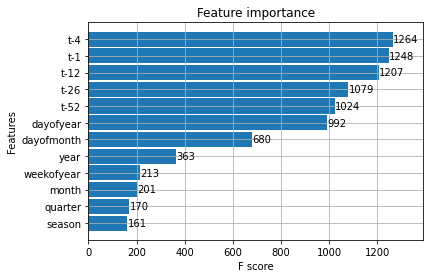

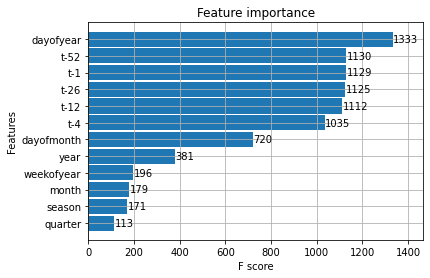

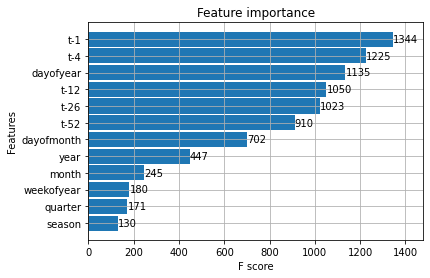

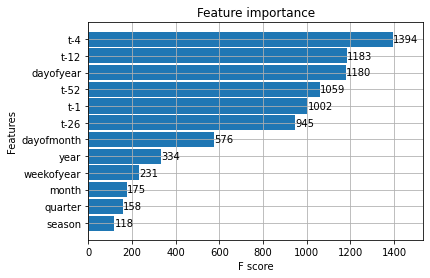

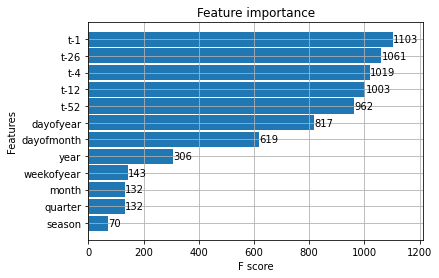

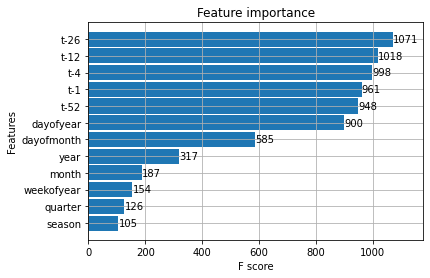

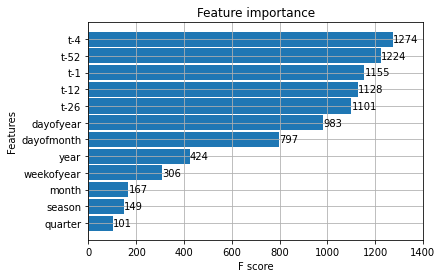

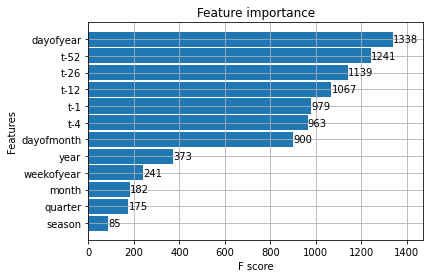

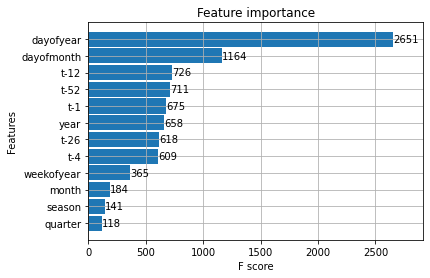

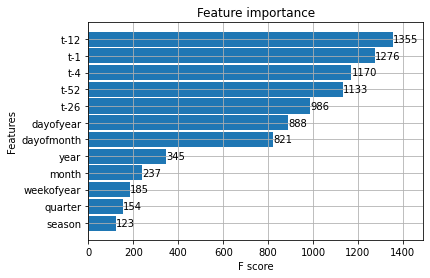

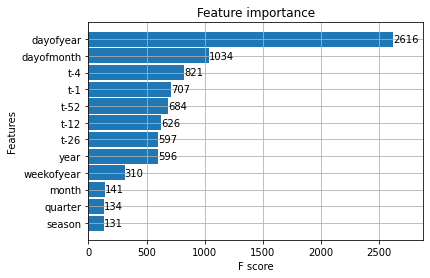

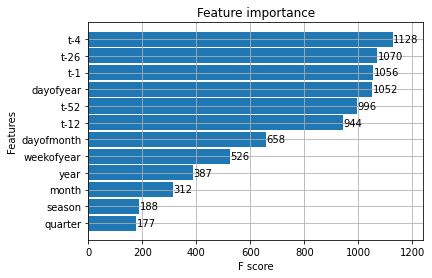

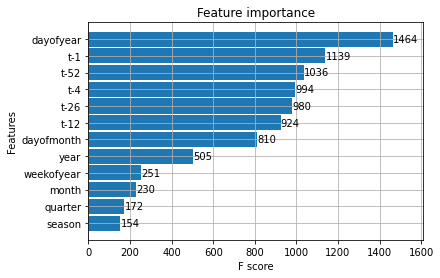

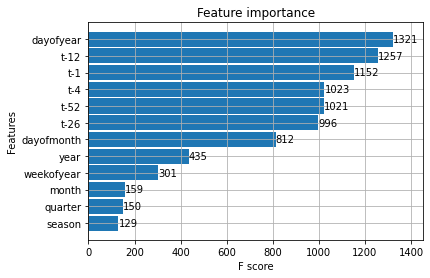

In [15]:
# specifying the path to csv files
path = ""
  
# csv files in the path
files = glob.glob(path + "/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/*.csv")

print(files)
  
# defining an empty list to store content
data_frame = pd.DataFrame()
content = []
  
# checking all the csv files in the specified path
for filename in files:

    
    df = pd.read_csv(filename, index_col=None)
    bobina_name = 'df_' + str(filename[-11:-4])
    globals()[str(bobina_name)] = pd.DataFrame(df)
    print(bobina_name)

    df1 = df.drop(columns="Unnamed: 0")

    n_test = 20
    
    data_train, data_test = train_test_split(df1, n_test)

    #Using the XGBoost functions on the csv for each raw material and saving them as dataframes

    best_params_xgb = timeseries_gridsearch_xgboost(df1)
    forecast_xgb = timeseries_forecast_xgboost(df1, best_params_xgb)

    params_xgboost_name= 'params_xgboost_' + str(filename[-11:-4])
    globals()[str(params_xgboost_name)] = pd.DataFrame(best_params_xgb)

    forecast_xgboost_name = 'forecast_xgboost_' + str(filename[-11:-4])
    globals()[str(forecast_xgboost_name)] = pd.DataFrame(forecast_xgb)

    test_xgboost_data = 'test_xgboost_' + str(filename[-11:-4])
    globals()[str(data_test)] = pd.DataFrame(data_test)

    #Using the Prophet functions on the csv for each raw material and saving them as dataframes

    best_params_prophet = timeseries_gridsearch_prophet(df1)
    forecast_prophet = timeseries_forecast_prophet(df1, best_params_prophet)
  
    params_prophet_name= 'params_prophet_' + str(filename[-11:-4])
    globals()[str(params_prophet_name)] = pd.DataFrame(best_params_prophet)

    forecast_prophet_name = 'forecast_prophet_' + str(filename[-11:-4])
    globals()[str(forecast_prophet_name)] = pd.DataFrame(forecast_prophet)

    test_prophet_data = 'test_prophet_' + str(filename[-11:-4])
    globals()[str(data_test)] = pd.DataFrame(data_test)

    metrics_comparison_name = 'metrics_comparison_' + str(filename[-11:-4])
    globals()[str(metrics_comparison_name)] = pd.DataFrame(performance_forecast_comparison(forecast_prophet =forecast_prophet, forecast_xgboost=forecast_xgb, df_test=data_test))


**Going through the time series csv files for each raw material, and returning the following:**


1.   Best performing model (XGBoost or Prophet)
2.   Best params for the best model
3.   Forecasted values for the specified time period
4.   Final forecast is exported as CSV
5.   Chart showing actual vs. forecasted values


['/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000116.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000120.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000123.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000117.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1000124.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1002902.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1002901.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1003430.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1004670.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1004431.csv', '/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/1006440.csv'

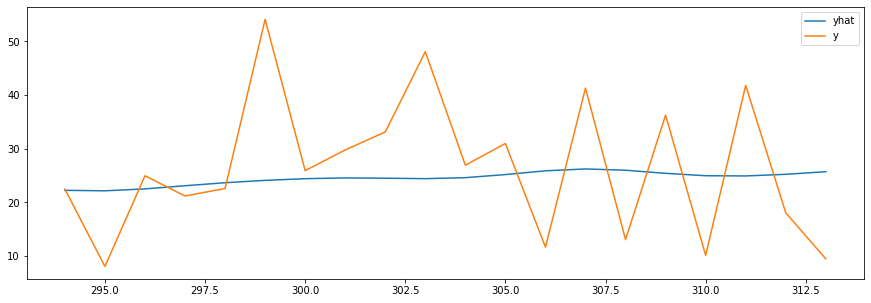

-------------------------------------------------------------------------------------------------------------------------------
1000120
PROPHET
      MAE      MSE                 MAPE                  WAPE
0  [3.84]  [35.34]  [222597249271889.3]  [0.9793036749300288]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper    real
293  2021-08-15       0.221      -8.819       8.847   5.225
294  2021-08-22       0.198      -8.546       9.013   1.013
295  2021-08-29       0.192      -8.722       8.916   0.000
296  2021-09-05       0.208      -9.619       9.453   3.041
297  2021-09-12       0.231      -9.653       9.618   1.329
298  2021-09-19       0.243      -8.772

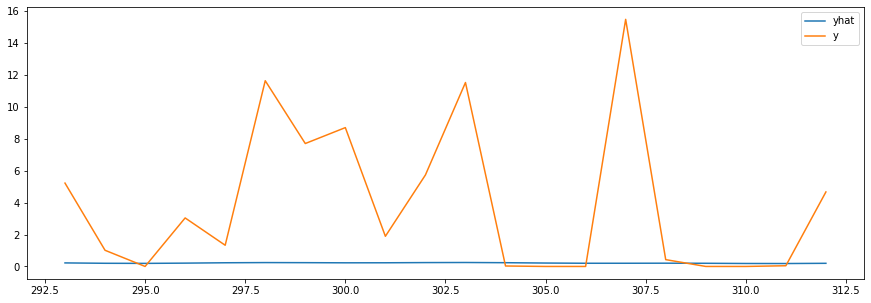

-------------------------------------------------------------------------------------------------------------------------------
1000123
PROPHET
       MAE        MSE    MAPE                  WAPE
0  [27.31]  [1225.66]  [3.41]  [0.4851778710711532]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper     real
294  2021-08-22      70.188     -61.914     207.995   14.876
295  2021-08-29      73.224     -65.880     204.198   48.253
296  2021-09-05      75.663     -54.146     211.506   82.651
297  2021-09-12      75.341     -55.025     204.109  120.301
298  2021-09-19      73.204     -61.774     212.623   47.635
299  2021-09-26      72.063     -63.236     207.257  

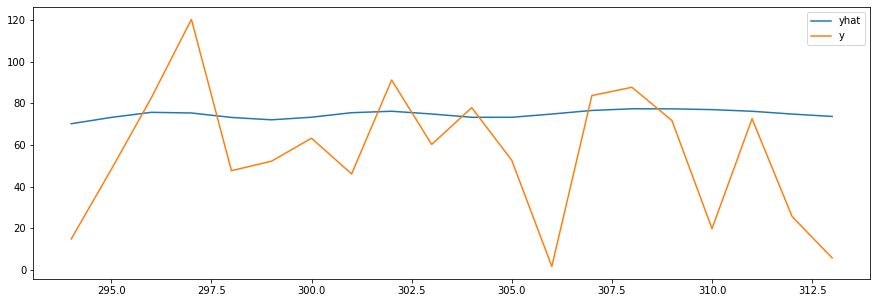

-------------------------------------------------------------------------------------------------------------------------------
1000117
PROPHET
      MAE       MSE    MAPE                  WAPE
0  [17.1]  [491.09]  [4.69]  [0.6131843761285777]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper    real
294  2021-08-22      17.484     -33.487      62.997  11.247
295  2021-08-29      18.669     -30.238      68.750  15.935
296  2021-09-05      20.079     -33.351      67.906   9.434
297  2021-09-12      20.504     -30.046      69.131  38.602
298  2021-09-19      19.660     -35.025      72.744   4.803
299  2021-09-26      18.593     -33.349      70.820  59.521
300

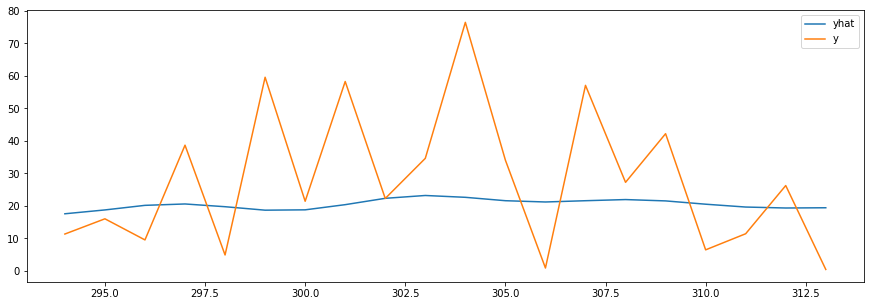

-------------------------------------------------------------------------------------------------------------------------------
1000124
PROPHET
      MAE      MSE                 MAPE                  WAPE
0  [6.15]  [76.69]  [538989497549680.4]  [0.8842418597071245]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper    real
294  2021-08-22       1.187     -18.852      19.129   5.774
295  2021-08-29       1.180     -17.086      19.294   6.041
296  2021-09-05       1.184     -16.628      19.439  17.765
297  2021-09-12       1.191     -15.607      19.024   0.000
298  2021-09-19       1.196     -18.650      21.370  15.592
299  2021-09-26       1.198     -17.992

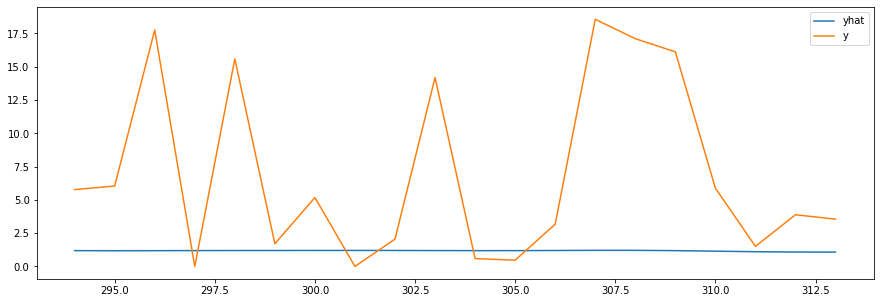

-------------------------------------------------------------------------------------------------------------------------------
1002902
XGBOOST
       MAE       MSE                  MAPE                  WAPE
0  [17.95]  [581.89]  [6680710818771764.0]  [0.8553306511312011]
                  param_values
param_key                     
colsample_bytree           0.7
learning_rate              0.1
max_depth                  3.0
n_estimators            1100.0
           date  prediction  pred_lower  pred_upper    real
293  2021-08-15   11.335000  -12.091000   36.250000  43.923
294  2021-08-22   -3.594000    2.838000   21.320000   2.147
295  2021-08-29    0.619000   -1.375000   25.533001  53.760
296  2021-09-05    1.446000   -2.202000   26.361000   6.327
297  2021-09-12    4.618000   -5.374000   29.532000   0.815
298  2021-09-19    0.684000   -1.440000   25.598000   3.037
299  2021-09-26   16.601999  -17.358000   41.515999  36.444
300  2021-10-03    5.924000   -6.680000   30.837999  49.250


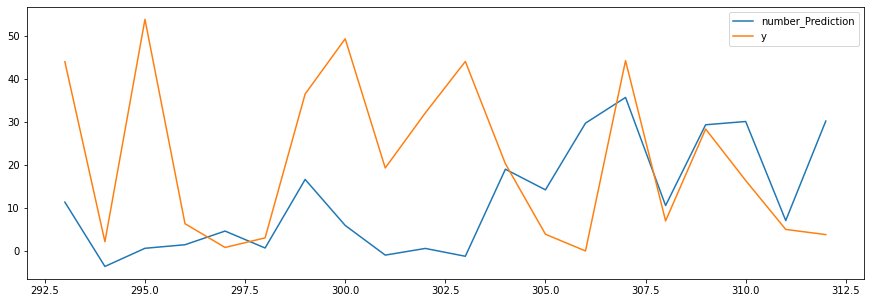

-------------------------------------------------------------------------------------------------------------------------------
1002901
PROPHET
       MAE        MSE                  MAPE                  WAPE
0  [38.92]  [8567.82]  [3251034419093977.5]  [0.8535473869688663]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper     real
292  2021-08-22      13.861     -38.175      67.170    1.575
293  2021-08-29      13.609     -39.966      65.322    8.725
294  2021-09-05      13.785     -35.304      65.165    1.292
295  2021-09-12      14.286     -38.414      67.884   57.677
296  2021-09-19      14.638     -36.889      69.001   30.171
297  2021-09-26      14.5

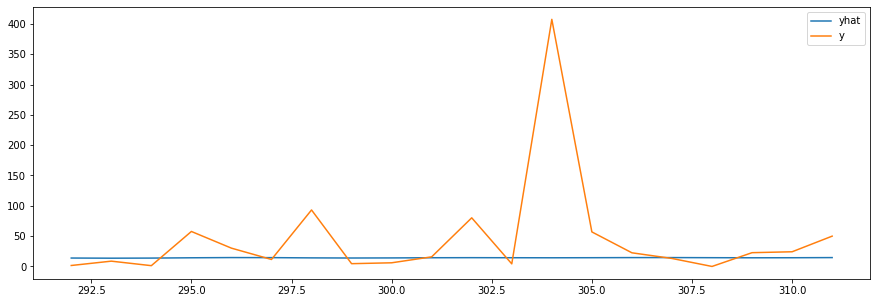

-------------------------------------------------------------------------------------------------------------------------------
1003430
PROPHET
       MAE        MSE                 MAPE                  WAPE
0  [14.91]  [1622.67]  [214721889210190.2]  [0.9897628972162593]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper     real
293  2021-08-22       0.521      -9.284      10.902    1.044
294  2021-08-29       0.429      -9.456      10.607    0.000
295  2021-09-05       0.402      -9.790       9.939    0.555
296  2021-09-12       0.427      -9.410      10.068   13.872
297  2021-09-19       0.449      -9.568      10.029    3.117
298  2021-09-26       0.403

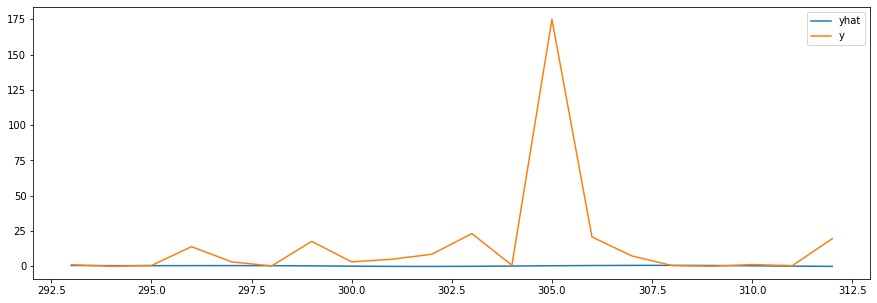

-------------------------------------------------------------------------------------------------------------------------------
1004670
PROPHET
      MAE     MSE                 MAPE                  WAPE
0  [0.51]  [0.68]  [29265775315079.34]  [0.9839442488059222]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper   real
289  2021-08-15       0.020      -0.999       1.091  0.000
290  2021-08-22       0.013      -1.034       1.109  0.680
291  2021-08-29       0.013      -1.103       1.083  0.000
292  2021-09-05       0.019      -1.122       1.084  0.000
293  2021-09-12       0.022      -1.079       1.106  0.000
294  2021-09-19       0.019      -1.034       1

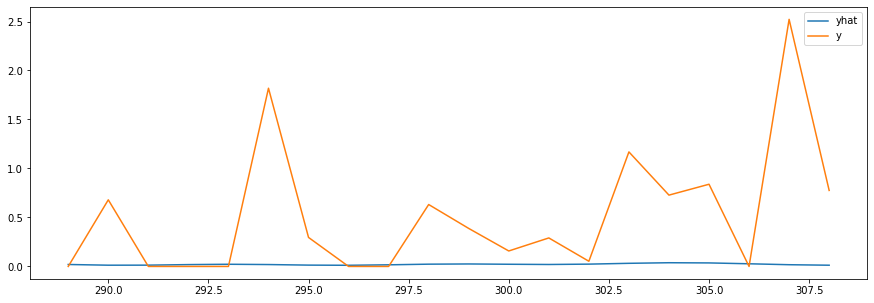

-------------------------------------------------------------------------------------------------------------------------------
1004431
XGBOOST
       MAE        MSE    MAPE                  WAPE
0  [36.09]  [2012.28]  [4.59]  [0.6901896054227327]
                  param_values
param_key                     
colsample_bytree          0.70
learning_rate             0.05
max_depth                 3.00
n_estimators           1300.00
           date  prediction  pred_lower  pred_upper     real
294  2021-08-22   52.792999   -0.655000   78.839996    5.331
295  2021-08-29   34.403999   17.733999   60.451000  131.073
296  2021-09-05   43.161999    8.976000   69.209000   14.762
297  2021-09-12   54.749001   -2.611000   80.796997   27.062
298  2021-09-19   28.341000   23.797001   54.389000   34.085
299  2021-09-26   40.863998   11.274000   66.911003   65.781
300  2021-10-03   23.056999   29.080999   49.104000  108.196
301  2021-10-10   30.035000   22.103001   56.082001   60.825
302  2021-10-17  

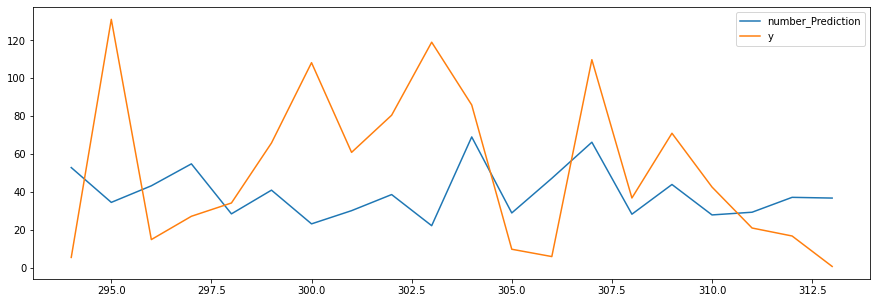

-------------------------------------------------------------------------------------------------------------------------------
1006440
PROPHET
      MAE       MSE                 MAPE                 WAPE
0  [6.21]  [223.72]  [926865200300716.4]  [1.011552159586177]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper    real
290  2021-08-15       0.258     -15.248      16.388  46.256
291  2021-08-22       0.344     -14.293      16.447   0.000
292  2021-08-29       0.666     -14.943      17.286   0.000
293  2021-09-05       0.865     -15.613      15.648   0.000
294  2021-09-12       0.648     -15.790      15.566   5.096
295  2021-09-19       0.175     -15.552

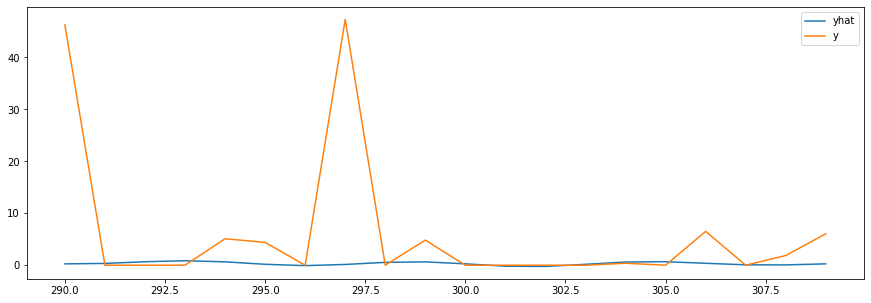

-------------------------------------------------------------------------------------------------------------------------------
1014989
PROPHET
      MAE     MSE    MAPE                  WAPE
0  [1.78]  [4.46]  [4.31]  [0.6240821490403796]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper   real
294  2021-08-22       3.257      -8.258      14.138  3.139
295  2021-08-29       3.353      -7.649      14.589  3.821
296  2021-09-05       3.447      -8.013      14.859  4.841
297  2021-09-12       3.449      -7.821      15.044  1.424
298  2021-09-19       3.373      -8.146      13.972  4.697
299  2021-09-26       3.323      -7.634      14.784  2.012
300  2021-10-0

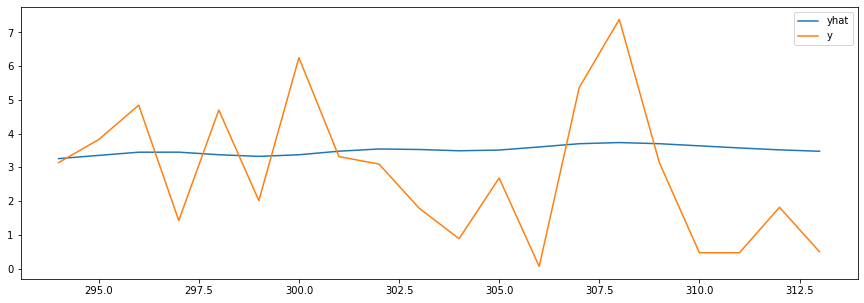

-------------------------------------------------------------------------------------------------------------------------------
1007700
XGBOOST
       MAE       MSE                      MAPE                  WAPE
0  [18.65]  [508.83]  [1.3904354197949644e+16]  [0.9775249447249355]
                  param_values
param_key                     
colsample_bytree           0.7
learning_rate              0.1
max_depth                  3.0
n_estimators            1300.0
           date  prediction  pred_lower  pred_upper    real
293  2021-08-15    8.434000  -14.573000   50.666000   3.957
294  2021-08-22   21.997999  -28.136000   64.228996  65.028
295  2021-08-29    9.310000  -15.449000   51.541000  16.871
296  2021-09-05   19.351000  -25.490000   61.583000   6.180
297  2021-09-12   36.109001  -42.247002   78.339996   0.000
298  2021-09-19   -2.368000   -3.771000   39.862999   0.000
299  2021-09-26    9.184000  -15.323000   51.416000   1.677
300  2021-10-03   10.453000  -16.591999   52.685001 

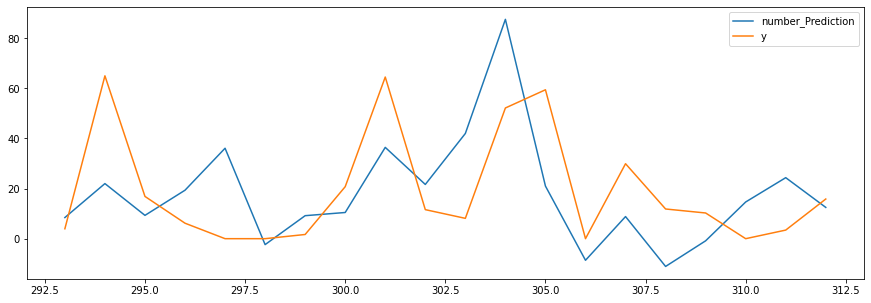

-------------------------------------------------------------------------------------------------------------------------------
1015101
PROPHET
      MAE     MSE                  MAPE                  WAPE
0  [0.28]  [0.18]  [116204217071490.69]  [0.7964575855865291]
                        param_values
param_key                           
changepoint_prior_scale        0.001
seasonality_prior_scale        0.005
growth                      logistic
yearly_seasonality              True
weekly_seasonality             False
daily_seasonality              False
seasonality_mode            additive
           date  prediction  pred_lower  pred_upper   real
294  2021-08-22       0.175      -0.987       1.314  0.232
295  2021-08-29       0.174      -1.009       1.282  0.313
296  2021-09-05       0.174      -0.892       1.362  1.289
297  2021-09-12       0.173      -0.963       1.363  0.000
298  2021-09-19       0.173      -0.920       1.363  0.548
299  2021-09-26       0.173      -0.992      

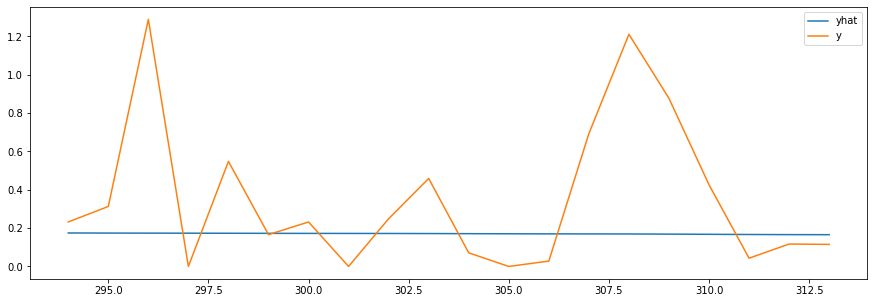

In [16]:
# specifying the path to csv files
path = ""
  
# csv files in the path
files = glob.glob(path + "/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final_csv/*.csv")
print(files)
  
# defining an empty list to store content
data_frame = pd.DataFrame()
content = []
  
# checking all the csv files in the specified path
for filename in files:


    df = pd.read_csv(filename, index_col=None)
    df1 = df.drop(columns="Unnamed: 0")
    n_test = 20
    
    data_train, data_test = train_test_split(df1, n_test)

    metrics = globals()[str('metrics_comparison_' + str(filename[-11:-4]))]

    if metrics['PROPHET']['WAPE'][0][0] <= metrics['XGBOOST']['WAPE'][0][0]:
      print('-------------------------------------------------------------------------------------------------------------------------------')
      print(filename[-11:-4])
      print('PROPHET')
      print(metrics['PROPHET'])
      params = globals()['params_prophet_' + str(filename[-11:-4])]
      print(params)
      forecast = globals()['forecast_prophet_' + str(filename[-11:-4])]    
      
      values = pd.DataFrame()
      values['date'] = data_test['ds'].tail(20)
      values['prediction'] = round(forecast['yhat'].tail(20),3)
      values['pred_lower'] = round(forecast['yhat_lower'].tail(20),3)
      values['pred_upper'] = round(forecast['yhat_upper'].tail(20),3)
      values['real'] = round(data_test['y'].tail(20),3)

      forecast_csv = values.to_csv('/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final Forecasts CSV/{}.csv'.format(str(filename[-11:-4])))
      
      print(values)

      print(f"Total tons predicted (5 months): {sum(forecast['yhat'].tail(20))}")
      print(f"Total tons test: {sum(data_test['y'].tail(20))}")
      plt.figure()
      forecast['yhat'].tail(20).plot(figsize=(15, 5),legend='Predicted')
      data_test['y'].tail(20).plot(figsize=(15, 5),legend='Real')
      plt.show()


    else: 
    #metrics['XGBOOST']['WAPE'][0][0].astype(int) < metrics['PROPHET']['WAPE'][0][0].astype(int):
      print('-------------------------------------------------------------------------------------------------------------------------------')
      print(filename[-11:-4])
      print('XGBOOST')
      print(metrics['XGBOOST'])
      params = globals()['params_xgboost_' + str(filename[-11:-4])]
      print(params)
      forecast = globals()['forecast_xgboost_' + str(filename[-11:-4])]
      
      values = pd.DataFrame()
      values['date'] = data_test['ds'].tail(20)
      values['prediction'] = round(forecast['number_Prediction'],3)
      values['pred_lower'] = round(forecast['pred_lower'],3)
      values['pred_upper'] = round(forecast['pred_upper'],3)
      values['real'] = round(data_test['y'].tail(20),3)

      forecast_csv = values.to_csv('/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Final Forecasts CSV/{}.csv'.format(str(filename[-11:-4])))

      print(values)
      print(f"Total tons predicted (5 months): {sum(forecast['number_Prediction'])}")
      print(f"Total tons test set: {sum(data_test['y'].tail(20))}")
      plt.figure()
      forecast['number_Prediction'].plot(figsize=(15, 5),legend='Predicted')
      data_test['y'].tail(20).plot(figsize=(15, 5),legend='Real')
      plt.show()